In [1]:
import pandas as pf
import tensorflow as tf
gpus =tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [2]:
(training_set, validation_set), dataset_info = tfds.load(
    'tf_flowers',
    split=['train[:70%]', 'train[70%:]'],
    with_info=True,
    as_supervised=True,
)

In [3]:
training_set

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [4]:
validation_set

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [5]:
num_classes = dataset_info.features['label'].num_classes
num_classes

5

In [6]:
num_training_examples = 0
num_validation_examples = 0
for example in training_set:
    num_training_examples += 1
for example in validation_set:
    num_validation_examples += 1
print('Total Number of Classes: {}'.format(num_classes))
print('Total Number of Training Images: {}'.format(num_training_examples))
print('Total Number of Validation Images: {} \n'.format(num_validation_examples))

Total Number of Classes: 5
Total Number of Training Images: 2569
Total Number of Validation Images: 1101 



In [7]:
for i, example in enumerate(training_set.take(5)):
    print('Image {} shape: {} label: {}'.format(i+1, example[0].shape, example[1]))

Image 1 shape: (333, 500, 3) label: 2
Image 2 shape: (212, 320, 3) label: 3
Image 3 shape: (240, 320, 3) label: 3
Image 4 shape: (240, 320, 3) label: 4
Image 5 shape: (317, 500, 3) label: 3


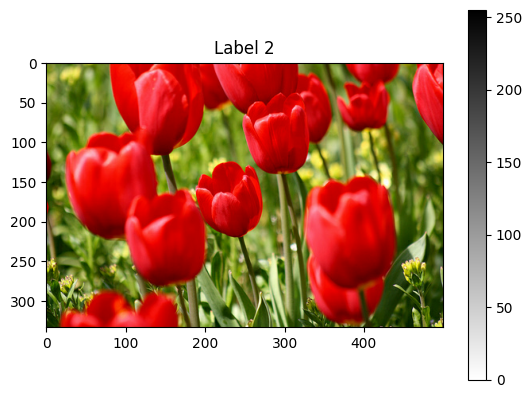

In [8]:
for image, label in training_set.take(1):
    break
image = image.numpy()
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.title('Label {}'.format(label))
plt.colorbar()
plt.grid(False)
plt.show()

In [9]:
IMAGE_RES = 256
def format_image(image, label):
    image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
    return image, label
BATCH_SIZE = 32
train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)
print(train_batches)
print(validation_batches)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

In [13]:
model=Sequential()

model.add(Conv2D(16,(3,3),1,activation='relu',input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32,(3,3),1,activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16,(3,3),1,activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256,activation='relu'))
model.add(Dense(5,activation='sigmoid'))

model.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 30, 30, 16)      

In [23]:
EPOCHS=100
history = model.fit(train_batches,epochs=EPOCHS,validation_data=validation_batches)

Epoch 1/100
81/81 [==============================] - 4s 47ms/step - loss: 0.0081 - accuracy: 0.9992 - val_loss: 2.4108 - val_accuracy: 0.6349
Epoch 2/100
81/81 [==============================] - 4s 47ms/step - loss: 0.0077 - accuracy: 0.9992 - val_loss: 2.3486 - val_accuracy: 0.6440
Epoch 3/100
81/81 [==============================] - 4s 47ms/step - loss: 0.0064 - accuracy: 0.9992 - val_loss: 2.3754 - val_accuracy: 0.6349
Epoch 4/100
81/81 [==============================] - 4s 47ms/step - loss: 0.0059 - accuracy: 0.9992 - val_loss: 2.3610 - val_accuracy: 0.6431
Epoch 5/100
81/81 [==============================] - 4s 48ms/step - loss: 0.0031 - accuracy: 0.9996 - val_loss: 2.7083 - val_accuracy: 0.6367
Epoch 6/100
81/81 [==============================] - 4s 47ms/step - loss: 0.0057 - accuracy: 0.9996 - val_loss: 2.3901 - val_accuracy: 0.6349
Epoch 7/100
81/81 [==============================] - 4s 46ms/step - loss: 0.0067 - accuracy: 0.9992 - val_loss: 2.3351 - val_accuracy: 0.6403
Epoch 

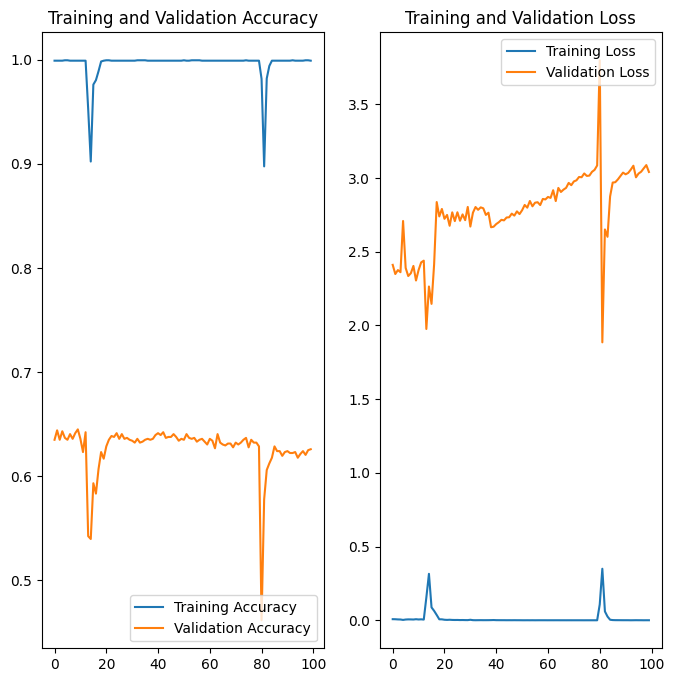

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(EPOCHS)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [25]:
class_names = np.array(dataset_info.features['label'].names)
print(class_names)

['dandelion' 'daisy' 'tulips' 'sunflowers' 'roses']


In [29]:
image_batch, label_batch = next(iter(train_batches))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()
predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
print(predicted_class_names)

1/1 [==============================] - 0s 34ms/step
['dandelion' 'roses' 'daisy' 'tulips' 'roses' 'sunflowers' 'daisy'
 'dandelion' 'sunflowers' 'dandelion' 'tulips' 'tulips' 'roses' 'roses'
 'dandelion' 'dandelion' 'tulips' 'daisy' 'sunflowers' 'daisy' 'dandelion'
 'dandelion' 'tulips' 'sunflowers' 'sunflowers' 'tulips' 'dandelion'
 'tulips' 'tulips' 'roses' 'sunflowers' 'daisy']


In [30]:
print("Labels:           ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:            [0 4 1 2 4 3 1 0 3 0 2 2 4 4 0 0 2 1 3 1 0 0 2 3 3 2 0 2 2 4 3 1]
Predicted labels:  [0 4 1 2 4 3 1 0 3 0 2 2 4 4 0 0 2 1 3 1 0 0 2 3 3 2 0 2 2 4 3 1]


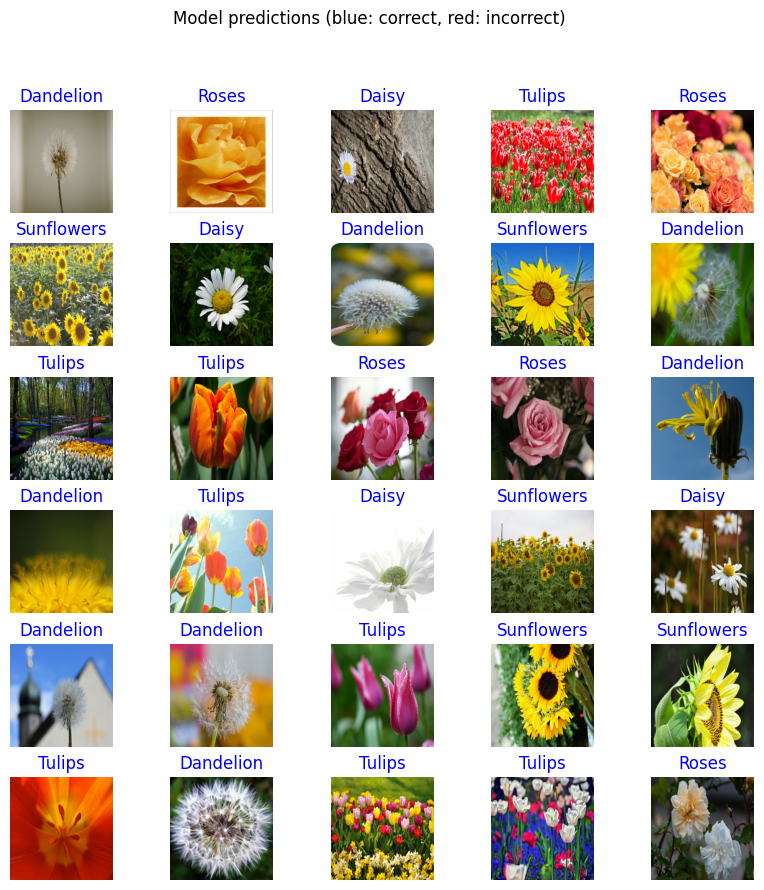

In [31]:
plt.figure(figsize=(10,10))
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.subplots_adjust(hspace = 0.3)
    plt.imshow(image_batch[n])
    color = "blue" if predicted_ids[n] == label_batch[n] else "red"
    plt.title(predicted_class_names[n].title(), color=color)
    plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")